In [1]:
import gc
import os
import random
import time
import pickle

import torch
import torchaudio
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import functional as F
from torchaudio.transforms import MelSpectrogram, Resample

import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

from librosa.filters import mel as librosa_mel_fn

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
class MelSpec(nn.Module):
    def __init__(self, conf: dict[str, any]):
        super().__init__()
        self.log_fn = conf.pop("log_fn", torch.log)
        self.norm_fn = conf.pop("norm_fn", None)
        self.featurizer = MelSpectrogram(**conf)

    def forward(self, audio):
        melspec = self.featurizer(audio).squeeze()
        melspec = self.log_fn(melspec.clamp(1e-5))
        if self.norm_fn:
            melspec = self.norm_fn(melspec)
        return melspec

In [6]:
class AudioDataset(Dataset):
    EFFECTS = [
        ["gain", "-n"],  # normalises to 0dB
        ["pitch", "5"],  # 5 cent pitch shift
    ]

    def __init__(self, root_dir, sample_rate, augment=True, segment_length=0):
        self.sample_rate = sample_rate
        self.segment_length = segment_length
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)
        self.augment = augment

    def __getitem__(self, index):
        data, sr = torchaudio.load(os.path.join(self.root_dir, self.files[index]))
        if sr != self.sample_rate:
            resampler = Resample(sr, self.sample_rate)
            data = resampler(data)

        if self.augment:
            data, _ = torchaudio.sox_effects.apply_effects_tensor(data, self.sample_rate, self.EFFECTS)
        
        # data = data.squeeze()
        if self.segment_length:
            if data.size(1) >= self.segment_length:
                max_audio_start = data.size(1) - self.segment_length
                audio_start = random.randint(0, max_audio_start)
                data = data[:, audio_start : audio_start + self.segment_length]
            else:
                data = F.pad(data, (0, self.segment_length - data.size(1)), "constant").data

        return data

    def __len__(self):
        return len(self.files)

In [7]:
SAMPLE_RATE = 22050
SEQ_LENGTH = 8192
N_FFT = 2048
WIN_LEN = 1024
HOP_LEN = 256
PAD = (N_FFT - HOP_LEN) // 2
MEC_SPEC_CONF_TACOTRON = dict(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_mels=80,
    f_min=40,
    f_max=8000,
    power=1,
    center=False,
    pad=PAD,
    mel_scale="slaney",
    norm="slaney",
)

In [8]:
SAMPLE_RATE = 24000
SEQ_LENGTH = 8192
N_FFT = 2048
WIN_LEN = int(SAMPLE_RATE * 0.05)
HOP_LEN = int(SAMPLE_RATE * 0.0125)
PAD = 640
MEC_SPEC_CONF_TACOTRON_VW = dict(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_mels=80,
    f_min=40,
    f_max=8000,
    power=1.2,
    pad=PAD,
    log_fn=lambda x: 20 * torch.log10(x),
    norm_fn=lambda x: torch.clamp((x + 100) / 100, 0, 1),
)

In [9]:
MEC_SPEC_CONF_TACOTRON_VW

{'sample_rate': 24000,
 'n_fft': 2048,
 'win_length': 1200,
 'hop_length': 300,
 'n_mels': 80,
 'f_min': 40,
 'f_max': 8000,
 'power': 1.2,
 'pad': 640,
 'log_fn': <function __main__.<lambda>(x)>,
 'norm_fn': <function __main__.<lambda>(x)>}

In [10]:
dataset = AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", SAMPLE_RATE, segment_length=SEQ_LENGTH)
dataset_val = AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", SAMPLE_RATE)
# mel_featurizer = MelSpec(MEC_SPEC_CONF_TACOTRON)
mel_featurizer = MelSpec(MEC_SPEC_CONF_TACOTRON_VW)

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

random_indexes = torch.randperm(len(dataset)).tolist()
dataset_train = Subset(dataset, random_indexes[:train_size])
dataset_test = Subset(dataset_val, random_indexes[train_size:])

# dataloader_train = 

In [11]:
len(dataset_train), len(dataset_test)

(106200, 11800)

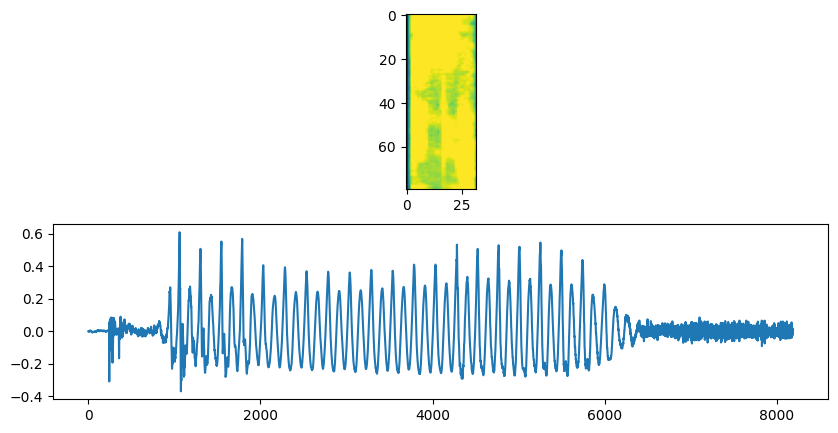

In [12]:
audio = dataset_train[0]
mel = mel_featurizer(audio)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mel)
axes[1].plot(audio[0])

display.Audio(audio, rate=dataset.sample_rate)

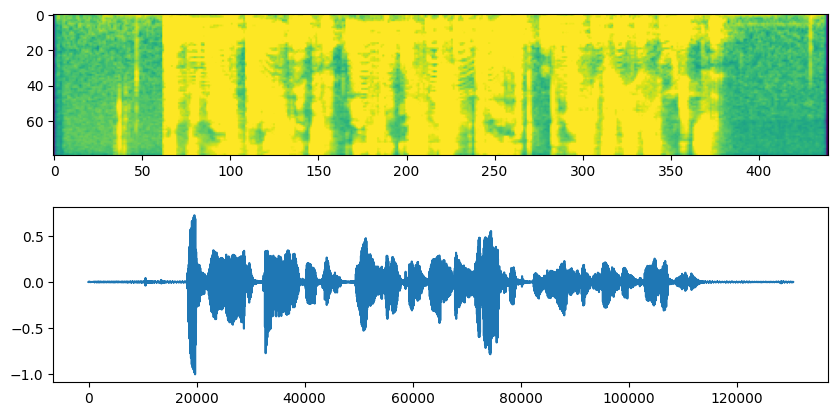

In [13]:
audio = dataset_test[0]
mel = mel_featurizer(audio)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mel)
axes[1].plot(audio[0])

display.Audio(audio, rate=dataset.sample_rate)

In [14]:
def collate_fn(items):
    audio_len = [audio.size(0) for audio in items]
    audio_batch = torch.zeros((len(items), max(audio_len)))
    for i, audio in enumerate(items):
        audio_batch[i, :audio_len[i]] = audio
    return audio_batch

In [15]:
dataloader_train = DataLoader(dataset_train, 32, shuffle=True, pin_memory=True, drop_last=True, num_workers=24)#, collate_fn=collate_fn)
dataloader_test = DataLoader(dataset_test, 1, pin_memory=True)

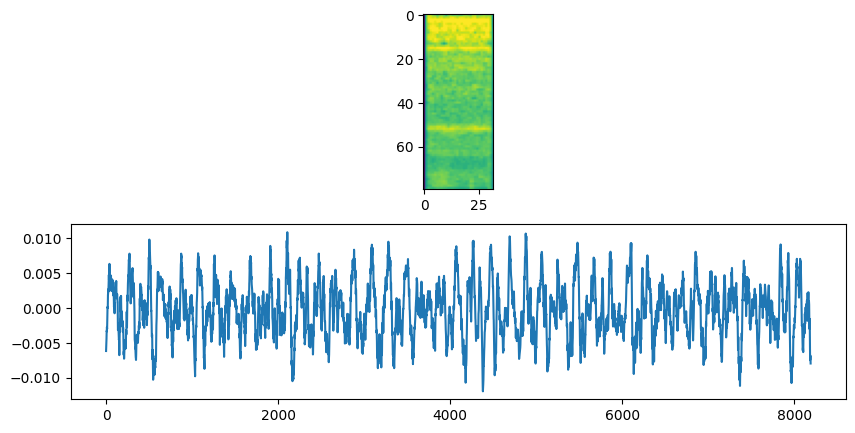

In [16]:
audios = next(iter(dataloader_train))
mels = mel_featurizer(audios)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].imshow(mels[0])
axes[1].plot(audios[0][0])

display.Audio(audios[0], rate=dataset.sample_rate)

In [17]:
# collate_dataloader = DataLoader(AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", 16000), 64, shuffle=True, pin_memory=True, drop_last=True, collate_fn=collate_fn)
# constcut_dataloader = DataLoader(AudioDataset("dataset/russian-open-stt/audio_dataset/audio_files", 16000, segment_length=100000), 64, shuffle=True, pin_memory=True, drop_last=True)
# for i, _ in enumerate(tqdm(collate_dataloader)):
#     if i >= 10: break
# for i, _ in enumerate(tqdm(constcut_dataloader)):
#     if i >= 10: break

In [18]:
from melgan import generator, discriminator
import importlib
importlib.reload(generator)
importlib.reload(discriminator)

from melgan.generator import Generator
from melgan.discriminator import Discriminator

In [19]:
D_LAYERS = 4
LAMBDA = 10
MODEL_TAG = "melgan_8192_24k_100_vw"

In [20]:
try:
    os.mkdir(f"models/{MODEL_TAG}")
    os.mkdir(f"models/{MODEL_TAG}/checkpoints")
    os.mkdir(f"models/{MODEL_TAG}/samples")
    print("ok")
except FileExistsError:
    print("already exists")

already exists


In [21]:
gen = generator.Generator(80, 32, 3).to(DEVICE)
disc = discriminator.Discriminator(3, 16, D_LAYERS, 4).to(DEVICE)

In [22]:
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [23]:
# mel_featurizer = MelSpec(MEC_SPEC_CONF_TACOTRON).to(DEVICE)
mel_featurizer = MelSpec(MEC_SPEC_CONF_TACOTRON_VW).to(DEVICE)

In [24]:
wav = next(iter(dataloader_train)).to(DEVICE)
mels = mel_featurizer(wav)
fake_wav = gen(mels)
disc_result = disc(fake_wav)
fake_mels = mel_featurizer(fake_wav)
print(wav.size(), fake_wav.size())
print(mels.size(), fake_mels.size())
print(disc_result[0][-1].size())

assert wav.size() == fake_wav.size()
assert mels.size() == fake_mels.size()
del wav
del fake_wav
del mels
del fake_mels
del disc_result
clear_mem()

torch.Size([32, 1, 8192]) torch.Size([32, 1, 8192])
torch.Size([32, 80, 32]) torch.Size([32, 80, 32])
torch.Size([32, 1, 32])


In [25]:
def disc_loss(D_fake, D_real):
    loss = 0
    for scale in D_fake:
        loss += F.relu(1 + scale[-1]).mean()
    for scale in D_real:
        loss += F.relu(1 - scale[-1]).mean()
    return loss

def gen_loss(D_fake):
    loss = 0
    for scale in D_fake:
        loss += -scale[-1].mean()
    return loss

def feature_loss(D_fake, D_real):
    loss_feat = 0
    feat_weights = 4.0 / (D_LAYERS + 1)
    D_weights = 1.0 / len(D_fake)
    wt = D_weights * feat_weights
    for i in range(len(D_fake)):
        for j in range(len(D_fake[i]) - 1):
            loss_feat += wt * F.l1_loss(D_fake[i][j], D_real[i][j].detach())
    return loss_feat

In [26]:
def train(epoch, gen, disc, opt_gen, opt_disc, dataloader):
    progress = tqdm(dataloader, desc=f"Train #{epoch}\n")
    
    losses = {
        "disc": [],
        "gen": [],
        "feature": [],
        "mel": [],
    }
    
    gen.train()
    disc.train()
    for wav in progress:
        wav = wav.to(DEVICE)
        mel = mel_featurizer(wav).detach()
        
        wav_fake = gen(mel)
        
        with torch.no_grad():
            mel_fake = mel_featurizer(wav_fake.detach())
            loss_mel = F.l1_loss(mel, mel_fake)
        
        D_fake = disc(wav_fake.detach())
        D_real = disc(wav)
        
        loss_D = disc_loss(D_fake, D_real)
        
        disc.zero_grad()
        loss_D.backward()
        opt_disc.step()
        
        D_fake = disc(wav_fake)
        loss_G = gen_loss(D_fake)
        loss_feat = feature_loss(D_fake, D_real)
        
        gen.zero_grad()
        (loss_G + LAMBDA * loss_feat).backward()
        opt_gen.step()
        
        losses["disc"].append(loss_D.item())
        losses["gen"].append(loss_G.item())
        losses["feature"].append(loss_feat.item())
        losses["mel"].append(loss_mel.item())
        
        progress.set_description((
            f"Epoch #{epoch} | "
            f"D: {loss_D.item():0.3} | "
            f"G: {loss_G.item():0.3} | "
            f"F: {loss_feat.item():0.3} | "
            f"M: {loss_mel.item():0.3}"
        ))
        
    return losses

In [27]:
def test(epoch, gen, disc, dataloader, n_samples=10):
    progress = tqdm(range(10), desc=f"Test #{epoch}\n")
    dataloader = iter(dataloader)

    gen.eval()
    disc.eval()
    with torch.no_grad():
        for i in progress:
            wav = next(dataloader)
            wav = wav.to(DEVICE)
            mel = mel_featurizer(wav).detach()

            wav_fake = gen(mel)

#             mel_fake = mel_featurizer(wav_fake)
#             loss_mel = F.l1_loss(mel, mel_fake)

#             D_fake = disc(wav_fake).squeeze()
#             D_real = disc(wav).squeeze()

#             loss_D = disc_loss(D_fake, D_real)
#             loss_G = gen_loss(D_fake)
#             loss_feat = feature_loss(D_fake, D_real)
            
            timestamp = str(int(time.time() * 1000))
            # torchaudio.save(f"models/{MODEL_TAG}/samples/{epoch}_{i}.wav", wav_fake.squeeze(0).cpu(), SAMPLE_RATE)
            torchaudio.save(f"models/{MODEL_TAG}/samples/{epoch}_{i}.wav", wav_fake.cpu(), SAMPLE_RATE)

In [35]:
torch.backends.cudnn.benchmark = True
EPOCHS = 100
EPOCH_OFFSET = 100
checkpoint = (EPOCH_OFFSET - 1) % 10

if EPOCH_OFFSET:
    gen.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/gen_{checkpoint}.pt", map_location="cuda"))
    opt_gen.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/opt_gen_{checkpoint}.pt", map_location="cuda"))
    disc.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/disc_{checkpoint}.pt", map_location="cuda"))
    opt_disc.load_state_dict(torch.load(f"models/{MODEL_TAG}/checkpoints/opt_disc_{checkpoint}.pt", map_location="cuda"))

try:
    train_losses = pickle.load(open(f"models/{MODEL_TAG}/losses", "rb"))
except:
    train_losses = []

In [36]:
len(train_losses)

85

In [ ]:
for epoch in range(EPOCH_OFFSET, EPOCHS + EPOCH_OFFSET):
    train_losses.append(train(epoch, gen, disc, opt_gen, opt_disc, dataloader_train))
    test(epoch, gen, disc, dataloader_test)
    
    checkpoint = epoch % 10
    torch.save(gen.state_dict(), f"models/{MODEL_TAG}/checkpoints/gen_{checkpoint}.pt")
    torch.save(opt_gen.state_dict(), f"models/{MODEL_TAG}/checkpoints/opt_gen_{checkpoint}.pt")
    torch.save(disc.state_dict(), f"models/{MODEL_TAG}/checkpoints/disc_{checkpoint}.pt")
    torch.save(opt_disc.state_dict(), f"models/{MODEL_TAG}/checkpoints/opt_disc_{checkpoint}.pt")

Train #100
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #100
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #101
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #101
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #102
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #102
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #103
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #103
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #104
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #104
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #105
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #105
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #106
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #106
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #107
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #107
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #108
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #108
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #109
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #109
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #110
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #110
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #111
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #111
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #112
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #112
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #113
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #113
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #114
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #114
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #115
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #115
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #116
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #116
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #117
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #117
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #118
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #118
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #119
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #119
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #120
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #120
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #121
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #121
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #122
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #122
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #123
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #123
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #124
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #124
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #125
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #125
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #126
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #126
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #127
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #127
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #128
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #128
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #129
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #129
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #130
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #130
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #131
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #131
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #132
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #132
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #133
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #133
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #134
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #134
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #135
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #135
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #136
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #136
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #137
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #137
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #138
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #138
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #139
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #139
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #140
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #140
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #141
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #141
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #142
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #142
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #143
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #143
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #144
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #144
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #145
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #145
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #146
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #146
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #147
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #147
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #148
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #148
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #149
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #149
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #150
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #150
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #151
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #151
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #152
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #152
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #153
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #153
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #154
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #154
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #155
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #155
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #156
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #156
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #157
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #157
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #158
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #158
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #159
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #159
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #160
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #160
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #161
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #161
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #162
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #162
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #163
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #163
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #164
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #164
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #165
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #165
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #166
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #166
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #167
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #167
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #168
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #168
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #169
:   0%|          | 0/3318 [00:00<?, ?it/s]

Test #169
:   0%|          | 0/10 [00:00<?, ?it/s]

Train #170
:   0%|          | 0/3318 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(16, 12))

for i, key in enumerate(["disc", "gen", "feature", "mel"]):
    plt.subplot(2, 2, i + 1)
    plt.plot(sum([losses[key] for losses in train_losses[6:]], start=[]), label=key)
    plt.title(key)
    
plt.grid()
plt.tight_layout()
plt.legend()

In [ ]:
pickle.dump(train_losses, open(f"models/{MODEL_TAG}/losses", "wb"))